# Final Project: Positive Speak

## Objective:
Explore two different datasets and see if there are any correlations between the data.
For this project I am going to compare the national GDP growth rate with the positivity of presidential speeches.

I wanted to learn a bit of Natural Language Processing and Sentiment analysis. In the 'learn' folder you can see some of the tutorials and testing I did. In the end, a self made machine learning model wasn't as accurate as using VADER Sentiment Analysis (which is built on NLTK).

With the testing out of the way I began working with the GDP data and Presidential speech data I found online.

Data Sources:
- Brown, D. W. (2016) Corpus of Presidential Speeches. Retrieved from http://www.thegrammarlab.com
- Louis Johnston and Samuel H. Williamson, "What Was the U.S. GDP Then?" MeasuringWorth, 2019 http://www.measuringworth.org/usgdp/

side-notes:
- An intresting project I found along the way. Sentiment through facial gestures. [One Angry Bird](https://emotions.periscopic.com/inauguration/)

In [1]:
# Import all our dependencies
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from os import listdir
from os.path import isfile, join

# import my GDP and Sentiment Helper files
from my_modules import GDPHelper
from my_modules import SentimentHelper

In [2]:
# File prep - unzip the presidential speech corpus
zf = ZipFile('./data/Corpus of Presidential Speeches.zip', 'r')
zf.extractall('./data')
zf.close()

## GDPHelper
This module takes in CPI and GDP data files and calculates the GDP growth rate. Part of that calculation, it also calculates the inflation rate.

In [3]:
# Specify Consumer Price Index data file and GDP data files    
cpi_fileinfo = GDPHelper.FileInfo('./data/USCPI_1774-2018.csv',
                                  'Year',
                                  'CPI'
                                 )

gdp_fileinfo = GDPHelper.FileInfo('./data/USGDP_1790-2018.csv',
                                  'Year',
                                  'Nominal GDP (million of Dollars)'
                                 )

# Create gdp dataset
gdp = GDPHelper.GDP(cpi_fileinfo, gdp_fileinfo)

## Our first plot!
The plot generated below is the GDP growth rate from about 1790 until 2018. I find it to be a decent indicator of how the us economy is doing. Also the growth rate fluctuates back and forth unlike the ever growing raw GDP.

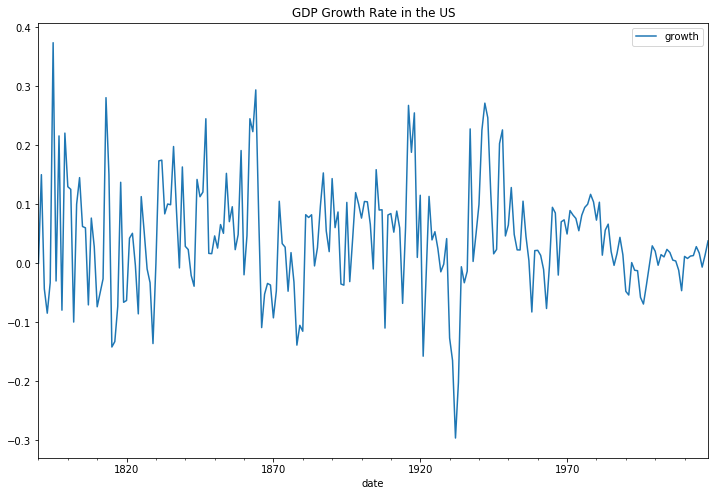

In [4]:
# increase plot sizes
fig_size = plt.rcParams.get('figure.figsize')
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams['figure.figsize'] = fig_size

growth_chat = gdp.gdp_data[['date', 'growth']].plot.line(x = 'date', y = 'growth')
plt.title('GDP Growth Rate in the US')
plt.show(growth_chat)

## On to the second dataset and plot
Below we use my **SentimentHelper** module to gather all the presidential speech files and extract a positivity score from them. Basically, it analyzes each sentence in a speech, then averages the score for the whole document. There can be multiple speeches in a year, so the plot has many more date points than the GDP data.
Lastly the positivity ranges from 1 (positive) to -1(negative).

This next cell may take a minute to process.

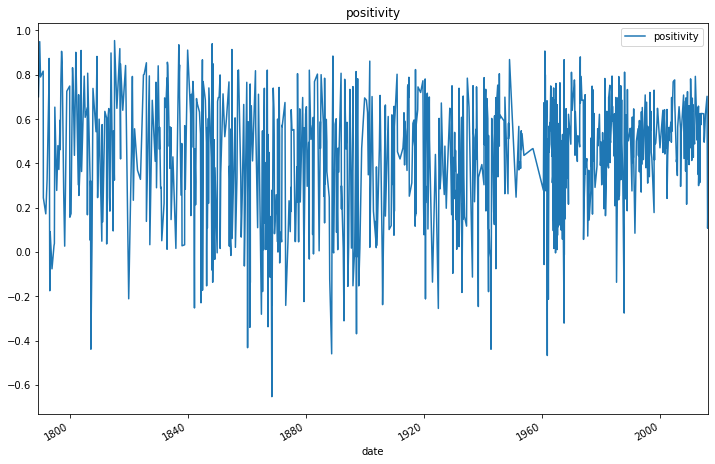

In [5]:
positivity_df = pd.DataFrame(columns=['date', 'person', 'title', 'positivity'])

speech_dir = './data/Corpus of Presidential Speeches'

all_speeches = SentimentHelper.get_all_files_in_subfolders(speech_dir)

positivity_df = SentimentHelper.batch_process_files(all_speeches, positivity_df);

positive_chart = positivity_df[['date', 'positivity']].plot.line(x = 'date', y = 'positivity')
plt.title('positivity')
plt.show(positive_chart)

If you're curious about the dataframes, here you go!

In [6]:
positivity_df

,date,person,title,positivity
0,1927-08-10,coolidge,Address at the Opening of Work on Mount Rushmo...,0.197658
1,1925-12-08,coolidge,Third Annual Message,0.672748
2,1923-12-06,coolidge,First Annual Message,0.440552
3,1925-10-20,coolidge,Message Regarding Relationship of Church and S...,0.349558
4,1925-03-04,coolidge,Inaugural Address,0.603195
...,...,...,...,...
957,1832-12-04,jackson,Fourth Annual Message to Congress,0.785653
958,1831-12-06,jackson,Third Annual Message to Congress,0.219797
959,1832-12-10,jackson,Nullification Proclamation,0.012618
960,1832-12-06,jackson,Veto Message of Internal Improvement Legislation,0.325621


In [7]:
gdp.gdp_data

,date,growth
0,1790-01-01,0.000000
1,1791-01-01,0.150255
2,1792-01-01,-0.043328
3,1793-01-01,-0.084617
4,1794-01-01,-0.032971
...,...,...
224,2014-01-01,0.028214
225,2015-01-01,0.017327
226,2016-01-01,-0.006498
227,2017-01-01,0.014124


## Time for the comparison
For this I am going to subtract the average of the positivity data from itself. That way the two dataset more closely overlap each other visually. In this chart I wouldn't pay much attention to the numbers on the y-axis. Also I will limit the date range so a bit more detail can be seen.

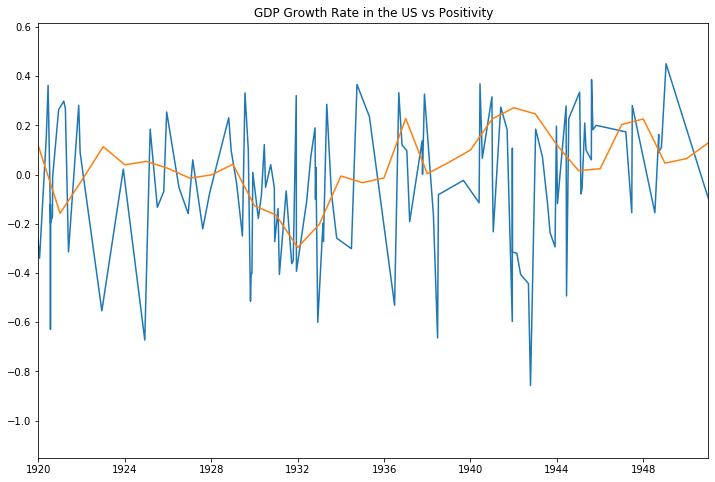

In [9]:
pos_avg = positivity_df['positivity'].mean()
def avg_diff(pos_score):
    return pos_score - pos_avg

positivity_df['pos_change'] = positivity_df['positivity'].apply(avg_diff)

plt.plot('date', 'pos_change', data= positivity_df.sort_values(by=['date']))
plt.plot('date', 'growth', data=gdp.gdp_data)
plt.title('GDP Growth Rate in the US vs Positivity')
plt.xlim([datetime.date(1920, 1, 1), datetime.date(1950, 12, 31)])
plt.show()

## Well...
It doesn't look like there is much correlation there. For the final plot I will have Pandas crunch a correlation matrix, and I will simplify the positivity to the avgerage for the whole year. I will also plot mean lines.

Correlation (-0.5 > corr OR corr > 0.5 is good)
              growth  positivity
growth      1.000000    0.048801
positivity  0.048801    1.000000


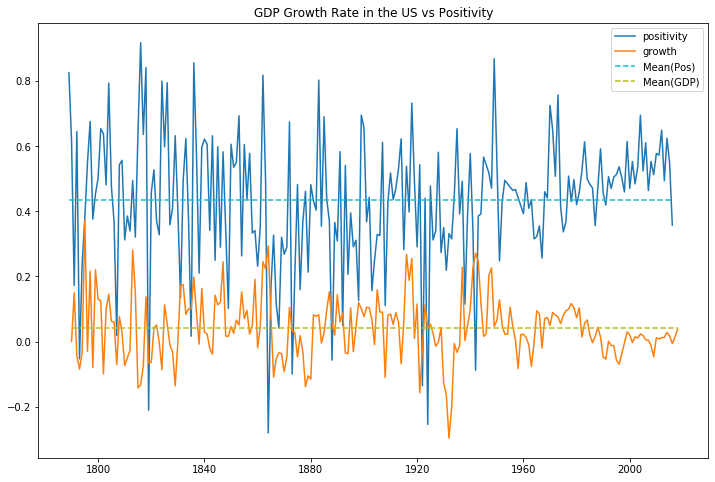

In [12]:
# copies of the datasets for working with
growth = gdp.gdp_data[['date', 'growth']]
speech = positivity_df[['date', 'positivity']]

# simplify the positivity to one score for the year
speech = speech.groupby(speech.date.dt.year)['positivity'].mean().reset_index()
# convert the date to a datetime object
speech['date'] = speech['date'].apply(GDPHelper.convert_year_int_to_date)

# Calculate the correlation Matrix
both = growth.merge(speech)
print('Correlation (-0.5 > corr OR corr > 0.5 is good)')
print(both.corr())

# mean values for plotting
pos_mean = speech['positivity'].mean() 
gdp_mean = growth['growth'].mean()
y_pos_mean = [pos_mean]*len(speech['date'])
y_gdp_mean = [gdp_mean]*len(growth['date'])

# Plot it all!
plt.plot('date', 'positivity', data= speech.sort_values(by=['date']))
plt.plot('date', 'growth', data=growth)
plt.plot(speech['date'], y_pos_mean, label='Mean(Pos)', linestyle='--', color='C9')
plt.plot(growth['date'], y_gdp_mean, label='Mean(GDP)', linestyle='--', color='C8')
plt.title('GDP Growth Rate in the US vs Positivity')
plt.legend()
# plt.xlim([datetime.date(1850, 1, 1), datetime.date(1900, 12, 31)])
plt.show()

## Conclusion
There isn't really any correlation! From my readings, a correlation value would be meaningful if it was above 0.5 and we only got 0.049. On the other hand I have learned some useful python skills! Sentiment Analysis, Pandas, and how to plot line charts!

That is all for now!